<h1>Contenidos<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Período-considerado" data-toc-modified-id="Período-considerado-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Período considerado</a></span></li><li><span><a href="#Uso-de-moneda-promedio-por-usuario-activo" data-toc-modified-id="Uso-de-moneda-promedio-por-usuario-activo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Uso de moneda promedio por usuario activo</a></span></li><li><span><a href="#Primer-evento" data-toc-modified-id="Primer-evento-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Primer evento</a></span></li><li><span><a href="#Los-usuarios-de-iOS-tienen-una-media-diaria-de-consumo-por-evento-mayor-a-los-de-Android" data-toc-modified-id="Los-usuarios-de-iOS-tienen-una-media-diaria-de-consumo-por-evento-mayor-a-los-de-Android-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Los usuarios de iOS tienen una media diaria de <em>consumo por evento</em> mayor a los de Android</a></span></li><li><span><a href="#Distancia-creación-evento" data-toc-modified-id="Distancia-creación-evento-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Distancia creación-evento</a></span></li><li><span><a href="#Eventos-con-importe-cero" data-toc-modified-id="Eventos-con-importe-cero-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Eventos con importe cero</a></span></li></ul></div>

In [1]:
import sys, os


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import HTML
# %matplotlib inline
sns.set()

In [2]:
# formarters
f_ar = lambda x: locale.format_string('%.2f', x, 1)
d_ar = lambda x: locale.format_string('%d', x, 1)

display_html = lambda x: display(HTML("<p>{}</p>".format(x)))


tz_arg = lambda x: pd.to_datetime(x).tz_localize('UTC').tz_convert(tz='America/Argentina/Buenos_Aires')

TABLE_COUNTER = 0
TABLE_TEMPLATE = """
<center><strong><small>{title}</small></strong></center>
<center>{table}</center>
<center><strong><small>Tabla {table_number}</small></strong></center>
"""
    
def table_counter():
    global TABLE_COUNTER
    TABLE_COUNTER += 1
    return TABLE_COUNTER

def add_style_to_df(df, subset, color='black', font_weight=None):
    render = df.style.set_properties(
        subset= subset, 
        **{'font-weight': font_weight, 'color':color}).render().replace('\n','')
    return render

def add_title(df_html, title):
    str_table = TABLE_TEMPLATE.format(title=title, table=df_html, table_number=table_counter())
    return str_table.replace('\n','')

def put_df_on_report(df, title, subset=None, color='black', font_weight='bold'):
    if subset:
        df_html = add_style_to_df(df, subset=subset,color=color, font_weight=font_weight)
    else:
        df_html = df.to_html().replace('\n','')
    return add_title(df_html, title)

In [3]:
def get_df_metadata(df):
    df_meta = df.dtypes.to_frame().rename({0:'dtypes'},axis=1)
    df_meta['count'] = df.count()
    df_meta['nulls'] = df.isnull().sum()
    df_meta['nunique'] = df.nunique()

    return df_meta

In [4]:
df = pd.read_csv('data_analyst_exercise_dataset.csv')

In [5]:
# convierto tipos y agrego columnas auxiliares
def get_week(d):
    start = d - pd.Timedelta(days=d.weekday())
    end = start + pd.Timedelta(days=6)
    return end

df['user_creation_time'] = pd.DatetimeIndex(df.user_creation_time)
df['event_time'] = pd.DatetimeIndex(df.event_time)
df['event_time_short'] = df['event_time'].dt.strftime("%Y-%m-%d")

df["event_hour"] = pd.DatetimeIndex(df.event_time).hour
df['event_weekday'] = pd.DatetimeIndex(df.event_time).weekday
df['event_weekdate_short'] = df["event_time"].apply(get_week).dt.strftime("%Y-%m-%d")

df['event_delay'] = (df.event_time - df.user_creation_time).dt.total_seconds()

In [35]:
# filtro los enventos anteriores a la creación del usuario
df = df[df.event_delay >= 0]

In [36]:
df = df.merge(pd.get_dummies(df.sink_channel),left_index=True, right_index=True)

In [37]:
# get_df_metadata(df)

In [38]:
# decido eliminar a los usuarios que tienen valores nulos para la columna balance.

balance_is_null = df.coins_balance.isnull()
user_null_balance = df.user_id.isin(df[balance_is_null].user_id.values)
# df[user_null_balance].shape
df.drop(index=df[balance_is_null].index, inplace=True)

# Período considerado

In [39]:
from_date = df.user_creation_time.dt.strftime("%Y-%m-%d").min()
end_date = df.event_time_short.max()
 
mssge = "Se cuenta con registros entre las fechas: {} y {}".format(from_date, end_date)
display_html(mssge)

# Uso de moneda promedio por usuario activo

Se entiende por _usuario activo_ aquel que registró transacciones para el período considerado.

In [40]:
df_arppu = df.groupby('event_time_short').agg({'user_id': pd.Series.nunique,
                                               'amount_spent': pd.Series.sum})

df_arppu['arppu'] = df_arppu.amount_spent / df_arppu.user_id

In [41]:
mean = df_arppu.arppu.mean()
str_mean = '{:0.2f}'.format(mean)
mssge = 'El uso promedio por usuario es de {} monedas.'.format(str_mean)
display_html(mssge)

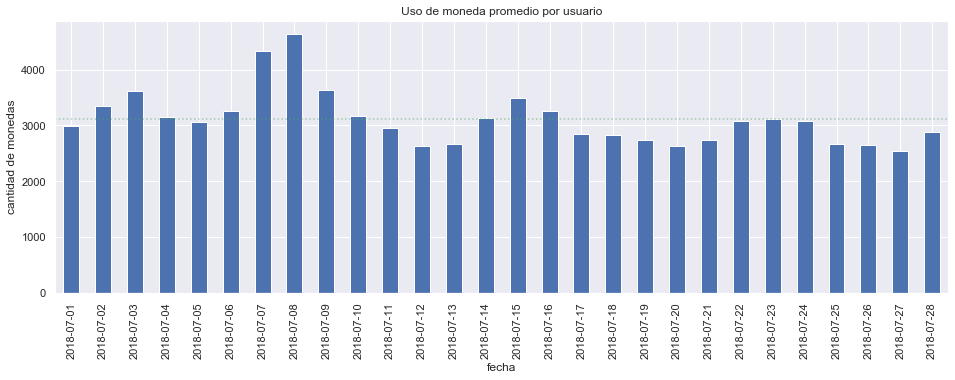

In [42]:
df_arppu.arppu.plot.bar(figsize=(16,5), color='b');
plt.hlines(y=mean, xmin=-1, xmax=30, linestyles='dotted', color='g', alpha=.5)
# plt.box(False)
plt.title('Uso de moneda promedio por usuario')
plt.xlabel('fecha')
plt.ylabel('cantidad de monedas');

# Primer evento

In [43]:
# df.groupby('user_id')['event_delay'].min().mean() / 60 / 60
df_usr_first_event = df.sort_values(['user_creation_time', 'event_time']).drop_duplicates('user_id', keep='first')

In [53]:
df_usr_first_event

,user_id,user_creation_time,platform,event_time,sink_channel,amount_spent,coins_balance,event_time_short,event_hour,event_weekday,...,sink_5_x,sink_6_x,sink_7_x,sink_1_y,sink_2_y,sink_3_y,sink_4_y,sink_5_y,sink_6_y,sink_7_y
1304383,55a9a601,2018-07-01 00:00:04.311,Android,2018-07-01 00:06:23.328,sink_1,320.0,1730.0,2018-07-01,0,6,...,0,0,0,1,0,0,0,0,0,0
1325030,9bb47bcd,2018-07-01 00:00:06.551,iOS,2018-07-07 02:29:08.794,sink_2,200.0,10950.0,2018-07-07,2,5,...,0,0,0,0,1,0,0,0,0,0
816850,2cdf6f31,2018-07-01 00:00:06.735,Android,2018-07-01 00:25:14.525,sink_2,1000.0,1550.0,2018-07-01,0,6,...,0,0,0,0,1,0,0,0,0,0
392399,c7677cbd,2018-07-01 00:00:12.229,Android,2018-07-01 15:45:12.850,sink_1,320.0,542230.0,2018-07-01,15,6,...,0,0,0,1,0,0,0,0,0,0
1304114,63072f7f,2018-07-01 00:00:29.130,Android,2018-07-01 00:12:31.429,sink_1,240.0,2285.0,2018-07-01,0,6,...,0,0,0,1,0,0,0,0,0,0
449494,7474e099,2018-07-01 00:00:34.169,Android,2018-07-01 01:08:50.861,sink_1,480.0,1545.0,2018-07-01,1,6,...,0,0,0,1,0,0,0,0,0,0
1549683,1ccf0146,2018-07-01 00:00:45.143,Android,2018-07-01 00:09:29.733,sink_1,320.0,2280.0,2018-07-01,0,6,...,0,0,0,1,0,0,0,0,0,0
962484,789cf310,2018-07-01 00:00:54.957,Android,2018-07-01 00:39:46.783,sink_1,240.0,5560.0,2018-07-01,0,6,...,0,0,0,1,0,0,0,0,0,0
169101,e87d825c,2018-07-01 00:00:58.090,Android,2018-07-01 00:13:05.624,sink_2,1000.0,2025.0,2018-07-01,0,6,...,0,0,0,0,1,0,0,0,0,0
1152846,ca9fe2a0,2018-07-01 00:01:13.972,Android,2018-07-01 03:17:37.064,sink_1,480.0,2220.0,2018-07-01,3,6,...,0,0,0,1,0,0,0,0,0,0


In [44]:
first_delay = df_usr_first_event.event_delay.mean() /60 /60
str_first_delay = '{:0.2f}'.format(first_delay)

mssge = 'En promedio un usuario tarda {} horas en realizar su primera transacción.'.format(str_first_delay)
display_html(mssge)

first_amount = df_usr_first_event.amount_spent.mean()
str_first_amount = '{:0.2f}'.format(first_amount)

mssge = 'El importe medio del primer evento es de {} monedas.'.format(str_first_amount)
display_html(mssge)

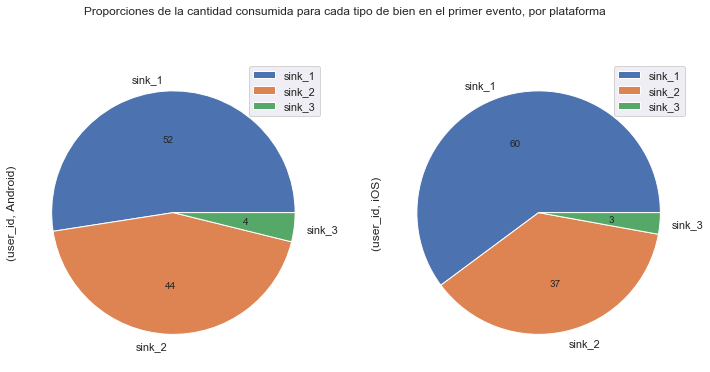

In [45]:
df_first = df_usr_first_event.groupby(['platform','sink_channel']).agg({'user_id': pd.Series.count,}).unstack(0)

main_sink = (df_first / df_first.sum() * 100) > 1
df_first[main_sink].dropna().plot.pie(autopct='%0.0f', subplots=True, figsize=(12,6));
plt.suptitle('Proporciones de la cantidad consumida para cada tipo de bien en el primer evento, por plataforma');


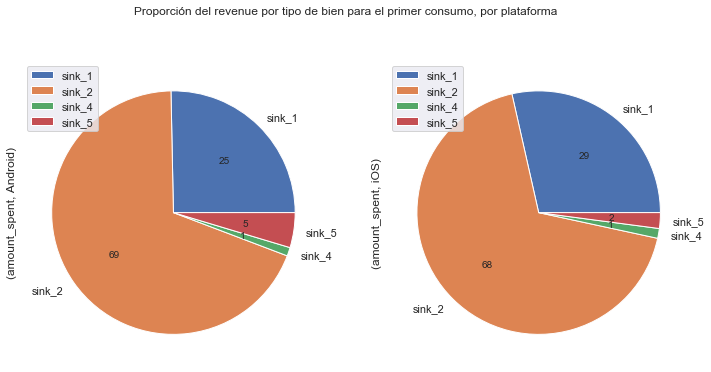

In [46]:
df_first = df_usr_first_event.groupby(['platform','sink_channel']).agg({'amount_spent': pd.Series.sum,}).unstack(0)

main_sink = (df_first / df_first.sum() * 100) > 1
df_first[main_sink].dropna().plot.pie(autopct='%0.0f', subplots=True, figsize=(12,6));
plt.suptitle('Proporción del revenue por tipo de bien para el primer consumo, por plataforma');


# Los usuarios de iOS tienen una media diaria de _consumo por evento_ mayor a los de Android

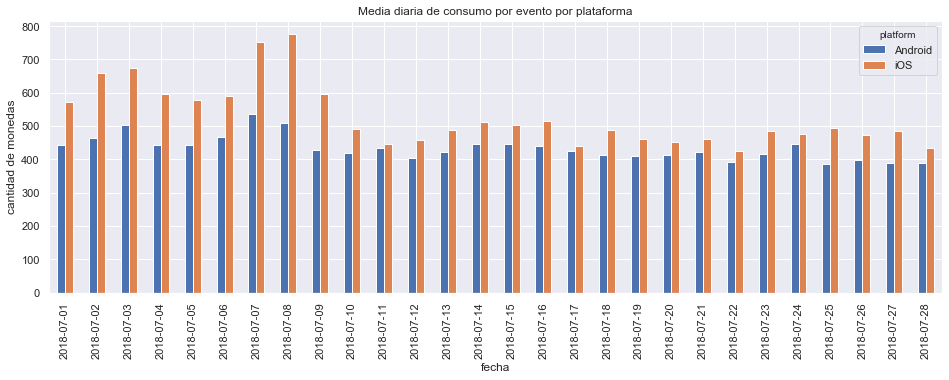

In [47]:
df_amount_by_platform = df.groupby(['event_time_short','platform']).agg({'amount_spent': [pd.Series.count,pd.Series.mean]}).unstack()

df_amount_by_platform['amount_spent']['mean'].plot.bar(figsize=(16,5));
plt.title('Media diaria de consumo por evento por plataforma')
plt.xlabel('fecha')
plt.ylabel('cantidad de monedas');


# Distancia creación-evento 

In [48]:
days_delay = df.event_delay /60 /60 / 24
days_delay.max()
mssg = 'En el período considerado, los usuarios registran eventos en una plazo máximo de {:.2f} días, a partir de instalar la aplicación.'.format(days_delay.max())
display_html(mssg)

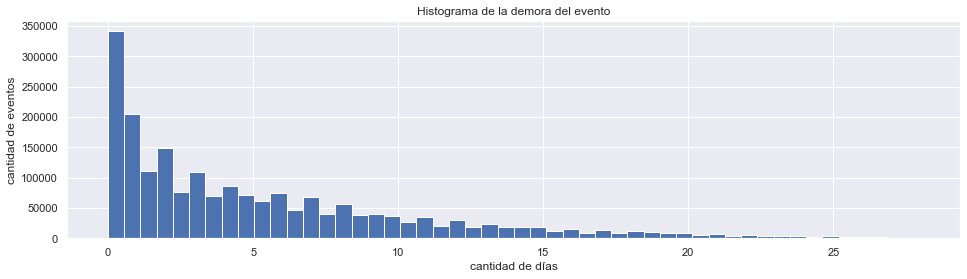

In [49]:
days_delay[days_delay>=0].hist(bins=50, figsize=(16,4))
plt.title('Histograma de la demora del evento')
plt.xlabel('cantidad de días')
plt.ylabel('cantidad de eventos');

# Eventos con importe cero

In [50]:
amount_is_zero = df.amount_spent == 0
df_aux = df[amount_is_zero].platform.value_counts().to_frame()
df_aux.rename({'platform':'events'},axis=1, inplace=True)
tabla_1 = put_df_on_report(df_aux, 'Eventos por plataforma')

df_aux = df[amount_is_zero].sink_channel.value_counts().to_frame()
df_aux.rename({'sink_channel':'events'},axis=1, inplace=True)
tabla_2 = put_df_on_report(df_aux, 'Eventos por tipo de bien/beneficio')

display(HTML(tabla_1))



,events
Android,87304
iOS,4


In [51]:
display(HTML(tabla_2))

,events
sink_1,87308


La propoción de eventos con importe cero varía entre el 3 y el 6% para el período considerado

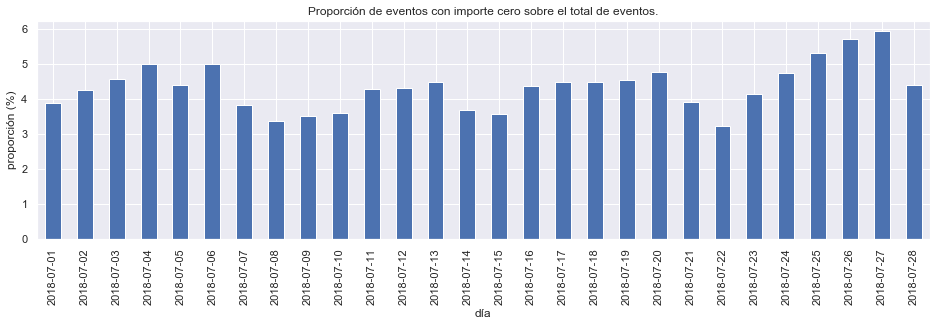

In [52]:
df_amount_zero = df[amount_is_zero].groupby('event_time_short')['user_id'].count().to_frame()
df_amount_zero['non_zero'] = df.groupby('event_time_short')['user_id'].count()

df_amount_zero['zero_rate'] = df_amount_zero.user_id / df_amount_zero['non_zero'] * 100

df_amount_zero.zero_rate.plot.bar(figsize=(16,4), color='b')
plt.title('Proporción de eventos con importe cero sobre el total de eventos.')
plt.xlabel('día')
plt.ylabel('proporción (%)');